## Code Modules & Functions

In [1]:
import sys
!cp ../input/rapids/rapids.0.16.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path=["/opt/conda/envs/rapids/lib/python3.7/site-packages"]+sys.path
sys.path=["/opt/conda/envs/rapids/lib/python3.7"]+sys.path
sys.path=["/opt/conda/envs/rapids/lib"]+sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,tensorflow as tf
import os,pylab as pl,cudf,cuml
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as sRFC
from cuml.ensemble import RandomForestClassifier as cRFC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier as sKNC
from cuml.neighbors import KNeighborsClassifier as cKNC
from sklearn.neural_network import MLPClassifier
import tensorflow.keras.preprocessing.image as tkimg
fpath='../input/tomato-cultivars/'

In [3]:
def images2array(files_path,img_size,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if grayscale:
            img=tkimg.load_img(
                img_path,grayscale=grayscale)
        else:
            img=tkimg.load_img(
                img_path,target_size=(img_size,img_size))
        img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),dtype='float32')

## Data

In [4]:
names=['Kumato','Beefsteak','Tigerella',
       'Roma','Japanese Black Trifele',
       'Yellow Pear','Sun Gold','Green Zebra',
       'Cherokee Purple','Oxheart','Blue Berries',
       'San Marzano','Banana Legs',
       'German Orange Strawberry','Supersweet 100']
flist=sorted(os.listdir(fpath))
labels=np.array(
    [int(el[:2]) for el in flist],dtype='int32')-1
img_size=160
images=images2array(fpath,img_size)
N=labels.shape[0]; n=int(.2*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_train=images[:n],images[n:]
y_test,y_train=labels[:n],labels[n:]

=>=>=>=>=>=>=>=>=>=>

In [5]:
pd.DataFrame([[x_train.shape,x_test.shape],
              [x_train.dtype,x_test.dtype],
              [y_train.shape,y_test.shape],
              [y_train.dtype,y_test.dtype]],               
             columns=['train','test'])

,train,test
0,"(621, 160, 160, 3)","(155, 160, 160, 3)"
1,float32,float32
2,"(621,)","(155,)"
3,int32,int32


Label:  0 Kumato


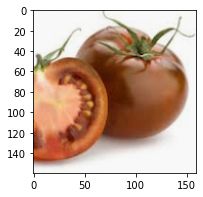

In [6]:
k=np.random.randint(40)
print('Label: ',y_test[k],
      names[y_test[k]])
pl.figure(figsize=(3,3))
pl.imshow((x_test[k]));

In [7]:
x_train=x_train.reshape(-1,img_size**2*3)
y_train=y_train.reshape(-1,1)
x_test=x_test.reshape(-1,img_size**2*3)
y_test=y_test.reshape(-1,1)

## Sklearn Classifiers

In [8]:
def classifier_fit_score(classifier,x_train,x_test,y_train,y_test):
    classifier.fit(x_train,y_train)     
    y_clf_train=classifier.predict(x_train)
    y_clf_test=classifier.predict(x_test)        
    acc_clf_train=round(accuracy_score(y_train,y_clf_train),4)
    acc_clf_test=round(accuracy_score(y_test,y_clf_test),4) 
    loss_clf_train=round(hamming_loss(y_train,y_clf_train),4)
    loss_clf_test=round(hamming_loss(y_test,y_clf_test),4)  
    return [y_clf_train,y_clf_test,acc_clf_train,acc_clf_test,
            loss_clf_train,loss_clf_test]

In [9]:
[y_srfc_train,y_srfc_test,acc_srfc_train,
 acc_srfc_test,loss_srfc_train,loss_srfc_test]=\
classifier_fit_score(sRFC(),x_train,x_test,y_train,y_test)
print(classification_report(y_test,y_srfc_test))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.32      0.50      0.39        14
           2       0.29      0.57      0.38        14
           3       0.33      0.36      0.35        11
           4       0.40      0.33      0.36         6
           5       0.31      0.42      0.36        12
           6       1.00      0.08      0.15        12
           7       0.73      0.85      0.79        13
           8       0.33      0.11      0.17         9
           9       0.00      0.00      0.00         8
          10       0.25      0.67      0.36         6
          11       0.33      0.08      0.12        13
          12       0.46      0.86      0.60         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00        15

    accuracy                           0.37       155
   macro avg       0.36      0.37      0.31       155
weighted avg       0.38   

In [10]:
#[y_crfc_train,y_crfc_test,acc_crfc_train,
# acc_crfc_test,loss_crfc_train,loss_crfc_test]=\
#classifier_fit_score(cRFC(),x_train,x_test,y_train,y_test)
#print(classification_report(y_test,y_crfc_test))

In [11]:
[y_lsvc_train,y_lsvc_test,acc_lsvc_train,
 acc_lsvc_test,loss_lsvc_train,loss_lsvc_test]=\
classifier_fit_score(svm.LinearSVC(),
                     x_train,x_test,y_train,y_test)
print(classification_report(y_test,y_lsvc_test))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.21      0.21      0.21        14
           2       0.27      0.29      0.28        14
           3       0.36      0.36      0.36        11
           4       0.11      0.17      0.13         6
           5       0.32      0.50      0.39        12
           6       0.50      0.25      0.33        12
           7       0.55      0.85      0.67        13
           8       0.33      0.22      0.27         9
           9       0.21      0.38      0.27         8
          10       0.50      0.50      0.50         6
          11       0.25      0.15      0.19        13
          12       0.29      0.29      0.29         7
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00        15

    accuracy                           0.32       155
   macro avg       0.31      0.32      0.30       155
weighted avg       0.31   

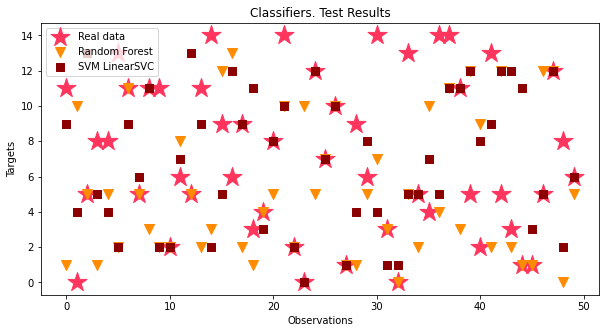

In [12]:
pl.figure(figsize=(10,5)); t=50; x=range(t)
pl.scatter(x,y_test[:t],marker='*',s=400,
           color='#ff355e',label='Real data')
pl.scatter(x,y_srfc_test[:t],marker='v',
           s=100,color='darkorange',label='Random Forest')
pl.scatter(x,y_lsvc_test[:t],marker='s',s=50,
           color='darkred',label='SVM LinearSVC')
pl.xlabel('Observations'); pl.ylabel('Targets') 
pl.title('Classifiers. Test Results')
pl.legend(loc=2,fontsize=10); pl.show()

In [13]:
[y_sknc_train,y_sknc_test,acc_sknc_train,
 acc_sknc_test,loss_sknc_train,loss_sknc_test]=\
classifier_fit_score(sKNC(),x_train,x_test,y_train,y_test)
print(classification_report(y_test,y_sknc_test))

              precision    recall  f1-score   support

           0       0.38      0.60      0.46        10
           1       0.13      0.14      0.14        14
           2       0.23      0.50      0.32        14
           3       0.13      0.27      0.18        11
           4       0.00      0.00      0.00         6
           5       0.35      0.67      0.46        12
           6       0.00      0.00      0.00        12
           7       0.47      0.69      0.56        13
           8       0.40      0.22      0.29         9
           9       0.00      0.00      0.00         8
          10       0.80      0.67      0.73         6
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00         7
          13       0.17      0.20      0.18         5
          14       0.00      0.00      0.00        15

    accuracy                           0.27       155
   macro avg       0.20      0.26      0.22       155
weighted avg       0.19   

In [14]:
[y_cknc_train,y_cknc_test,acc_cknc_train,
 acc_cknc_test,loss_cknc_train,loss_cknc_test]=\
classifier_fit_score(cKNC(),x_train,x_test,y_train,y_test)
print(classification_report(y_test,y_cknc_test))

              precision    recall  f1-score   support

           0       0.38      0.60      0.46        10
           1       0.13      0.14      0.14        14
           2       0.23      0.50      0.32        14
           3       0.13      0.27      0.18        11
           4       0.00      0.00      0.00         6
           5       0.35      0.67      0.46        12
           6       0.00      0.00      0.00        12
           7       0.47      0.69      0.56        13
           8       0.40      0.22      0.29         9
           9       0.00      0.00      0.00         8
          10       0.80      0.67      0.73         6
          11       0.00      0.00      0.00        13
          12       0.00      0.00      0.00         7
          13       0.17      0.20      0.18         5
          14       0.00      0.00      0.00        15

    accuracy                           0.27       155
   macro avg       0.20      0.26      0.22       155
weighted avg       0.19   

In [15]:
mlpc=MLPClassifier(hidden_layer_sizes=(512,),
                   max_iter=60,solver='sgd',
                   verbose=1,random_state=1,
                   learning_rate_init=.005)
[y_mlpc_train,y_mlpc_test,acc_mlpc_train,
 acc_mlpc_test,loss_mlpc_train,loss_mlpc_test]=\
classifier_fit_score(mlpc,x_train,x_test,y_train,y_test)

Iteration 1, loss = 5.96698243
Iteration 2, loss = 16.60929765
Iteration 3, loss = 4.08546831
Iteration 4, loss = 2.67914324
Iteration 5, loss = 2.59008448
Iteration 6, loss = 2.57407811
Iteration 7, loss = 2.39171220
Iteration 8, loss = 2.31379920
Iteration 9, loss = 2.10357334
Iteration 10, loss = 2.02647519
Iteration 11, loss = 2.02676062
Iteration 12, loss = 1.86660370
Iteration 13, loss = 1.81006479
Iteration 14, loss = 1.77244123
Iteration 15, loss = 1.69618000
Iteration 16, loss = 1.64785758
Iteration 17, loss = 1.56969211
Iteration 18, loss = 1.49360602
Iteration 19, loss = 1.57185163
Iteration 20, loss = 1.43560825
Iteration 21, loss = 1.47461041
Iteration 22, loss = 1.57455854
Iteration 23, loss = 1.33190580
Iteration 24, loss = 1.35181674
Iteration 25, loss = 1.34013998
Iteration 26, loss = 1.32011295
Iteration 27, loss = 1.34742320
Iteration 28, loss = 1.49406443
Iteration 29, loss = 1.18463769
Iteration 30, loss = 1.19566680
Iteration 31, loss = 1.26339582
Iteration 32, lo

In [16]:
print(classification_report(y_test,y_mlpc_test))

              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.50      0.07      0.12        14
           2       0.67      0.29      0.40        14
           3       0.24      0.91      0.38        11
           4       0.21      0.83      0.33         6
           5       0.50      0.08      0.14        12
           6       0.33      0.17      0.22        12
           7       0.89      0.62      0.73        13
           8       0.33      0.22      0.27         9
           9       0.00      0.00      0.00         8
          10       0.33      0.33      0.33         6
          11       0.00      0.00      0.00        13
          12       0.25      0.71      0.37         7
          13       0.20      0.40      0.27         5
          14       0.33      0.07      0.11        15

    accuracy                           0.28       155
   macro avg       0.34      0.32      0.26       155
weighted avg       0.37   

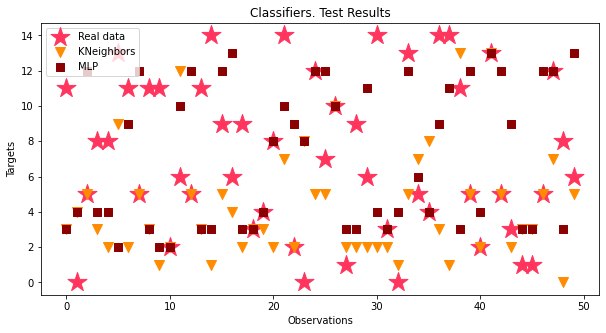

In [17]:
pl.figure(figsize=(10,5)); t=50; x=range(t)
pl.scatter(x,y_test[:t],marker='*',s=400,
           color='#ff355e',label='Real data')
pl.scatter(x,y_sknc_test[:t],marker='v',
           s=100,color='darkorange',label='KNeighbors')
pl.scatter(x,y_mlpc_test[:t],marker='s',s=50,
           color='darkred',label='MLP')
pl.xlabel('Observations'); pl.ylabel('Targets') 
pl.title('Classifiers. Test Results')
pl.legend(loc=2,fontsize=10); pl.show()

In [18]:
acc_train=[acc_srfc_train,acc_lsvc_train,
           acc_sknc_train,acc_mlpc_train]
acc_test=[acc_srfc_test,acc_lsvc_test,
          acc_sknc_test,acc_mlpc_test]
loss_train=[loss_srfc_train,loss_lsvc_train,
            loss_sknc_train,loss_mlpc_train]
loss_test=[loss_srfc_test,loss_lsvc_test,
           loss_sknc_test,loss_mlpc_test]
cols=['Random Forest','SVM LinearSVC',
      'KNeighbors','MLP']
pd.DataFrame([acc_train,acc_test,
              loss_train,loss_test],
            index=['accuracy train','accuracy test',
                   'loss train','loss test'],
            columns=cols)

,Random Forest,SVM LinearSVC,KNeighbors,MLP
accuracy train,1.0000,1.0000,0.5089,0.7440
accuracy test,0.3677,0.3226,0.2710,0.2839
loss train,0.0000,0.0000,0.4911,0.2560
loss test,0.6323,0.6774,0.7290,0.7161
